https://www.kaggle.com/datasets/govtrades/sba-paycheck-protection-program-loan-data?select=foia_up_to_150k_IL.csv

https://www.kaggle.com/datasets/oyeboludaniel/2017-naics-codes-summary

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
#from itertools import permutations
from sklearn.utils import shuffle

<h3>Predicting Jobs Saved from PPP Loans During Early Covid Crisis (April-June 2020)</h3>

<h4>Project Motivation</h4>

In the early days of the Covid Pandemic, the US Congress created the Paycheck Protection Program (PPP) to give loans to organizations impacted by the virus's economic fallout in an effort to preserve jobs while commercial activity contracted. The PPP application process included providing certain descriptive information about the organization seeking a loan, including the number of jobs to be protected. This data was later made public by the US Treasury. I will be using this data for loans in the state of Missouri to create a regression model predicting the number of jobs saved in order to understand the impact of an organization's descriptive variables on the effectiveness of PPP loans in retaining jobs.
    
<h4>Data</h4>

Originally, the data was collected from loan applications and then publicized by the Treasury, but I am going to use a copy of the data hosted on Kaggle. The data is tabular, consisting of 14 columns and 80,035 rows. To categorize the NAICS codes (explained later) I will also be using NAICS categorical data from the US Census Bureau.

<h4>Citations</h4>

(2020, July 6). SBA Paycheck Protection Program (PPP) Loan Data. Kaggle. Retrieved July 19, 2023, from https://www.kaggle.com/datasets/govtrades/sba-paycheck-protection-program-loan-data?select=foia_up_to_150k_MO.csv

United States Census Bureau (2023, July 19). North American Industry Classification System. Census.gov. Retrieved July 19, 2023, from https://www.census.gov/naics/?58967?yearbck=2017


In [2]:
data = pd.read_csv('foia_up_to_150k_MO.csv')
naics = pd.read_csv('2017_NAICS_Structure_Summary_Table .csv')

In [3]:
data.head(3)

,LoanAmount,City,State,Zip,NAICSCode,BusinessType,RaceEthnicity,Gender,Veteran,NonProfit,JobsRetained,DateApproved,Lender,CD
0,149961.00,KANSAS CITY,MO,64108,541990.0,Limited Liability Company(LLC),Unanswered,Unanswered,Unanswered,NaN,13.0,04/13/2020,Country Club Bank,MO - 05
1,149927.67,O FALLON,MO,63366,722511.0,Subchapter S Corporation,Unanswered,Unanswered,Unanswered,NaN,NaN,04/07/2020,"First State Bank of St. Charles, Missouri",MO - 02
2,149900.00,RAYTOWN,MO,64133,441120.0,Corporation,White,Male Owned,Unanswered,NaN,14.0,05/11/2020,Blue Ridge Bank and Trust Co.,MO - 05


<h3>Exploratory Data Analysis</h3>

I start by getting an idea of the distribution of values in the (mostly) categorical variables:

In [4]:
for col in data.columns:
    unique_values = data[col].nunique()
    modal_value = data[col].mode()[0]
    print(col,'unique values =',unique_values,', modal value =',modal_value)

LoanAmount unique values = 29634 , modal value = 20800.0
City unique values = 1175 , modal value = SAINT LOUIS
State unique values = 1 , modal value = MO
Zip unique values = 1033 , modal value = 65804
NAICSCode unique values = 1002 , modal value = 722511.0
BusinessType unique values = 16 , modal value = Limited  Liability Company(LLC)
RaceEthnicity unique values = 6 , modal value = Unanswered
Gender unique values = 3 , modal value = Unanswered
Veteran unique values = 3 , modal value = Unanswered
NonProfit unique values = 1 , modal value = Y
JobsRetained unique values = 120 , modal value = 1.0
DateApproved unique values = 79 , modal value = 04/28/2020
Lender unique values = 838 , modal value = U.S. Bank, National Association
CD unique values = 8 , modal value = MO - 01


<h4> Variable Overview </h4>

* LoanAmount - this is the only continuous predictor variable and will likely be driving the model. Other (categorical) variables will be used as adjusting the primary expected relationship of higher LoanAmount: higher JobsRetained

* City - this variable is categorical and has too many distinct values to be readily usable by the model. As we'll see in the CD section though, there are other ways to capture regional effects than this variable.

* State - this dataset is limited to the state of Missouri (~80K records) out of the total number of PPP loans which numbered in the millions. As a result this field has 1 value that won't be useful for the model.

* Zip - similar to City in that it is categorical with a large number of categories, making it hard to use for the model.

* NAICSCODE - this variable categorizes business using the North American Industry Classification System to classify each organization. While at first glance it has a similar issue as City and Zip, the classification system is hierarchical and thus this variable can be organized into 20 distinct industrial classifications and potentially fewer by lumping small groupings into an "other" category.

* BusinessType - this categorical variable has 16 distinct values describing the type of organization applying for a PPP loan, for instance Sole Proprietorships vs Corporations. These can be used in a straightforward way as categorical "dummy" variables in the model.

* RaceEthnicity, Gender, Veteran - these variables have a very high non-response rate and will likely be unusable as a result.

* NonProfit - this is a boolean variable that will be easily used in the model to flag whether or not the loan applicant is a non-profit entity.

* JobsRetained - this is the output variable I will be trying to predict: the number of jobs retained by the organization as a result of the PPP loan.

* DateApproved - this is a categorical variable with many unique values representing the date of the loan's approval. I will be simplifying this into weeks or months in order to work with fewer categorical variables in the model.

* Lender - this is the lender bank associated with the loan. Since there are many unique categorical values I will discard this one.

* CD - this is the congressional district of the loan applicant. As there are 8 congressional districts with essentially equal population in the state of Missouri, these can be used as a categorical variable proxy for regional effects.

<h4>Variables: RaceEthnicity, Gender, Veteran</h4>
Several of the categorical variables have a modal value of "Unanswered". If they make up a substantial portion of the total data then those variables will need to be discarded. Let's check that.

In [5]:
for col in ['RaceEthnicity','Gender','Veteran']:
    print(col,':')
    print(data[col].value_counts())
    print('')

RaceEthnicity :
Unanswered                          66333
White                               12492
Asian                                 503
Black or African American             349
Hispanic                              299
American Indian or Alaska Native       59
Name: RaceEthnicity, dtype: int64

Gender :
Unanswered      55790
Male Owned      17494
Female Owned     6751
Name: Gender, dtype: int64

Veteran :
Unanswered     67375
Non-Veteran    12065
Veteran          595
Name: Veteran, dtype: int64



As suspected, the vast majority of values in each of these categorical variables is "Unanswered", so we will discard them from the model.

<h4>Variables: LoanAmount, JobsRetained</h4>

Now, let's take a look at the two continuous variables:

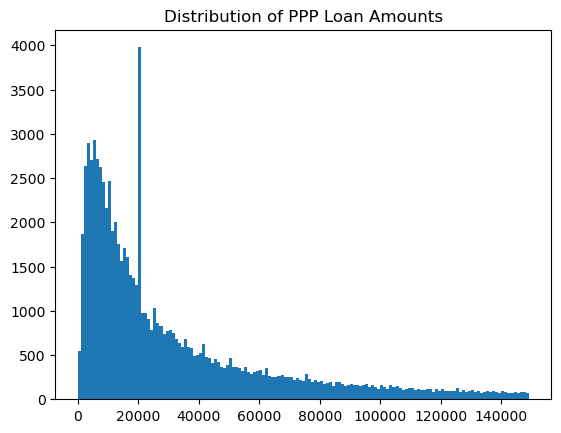

In [6]:
plt.hist(data['LoanAmount'],bins=np.arange(0,150000,1000))
plt.title('Distribution of PPP Loan Amounts');

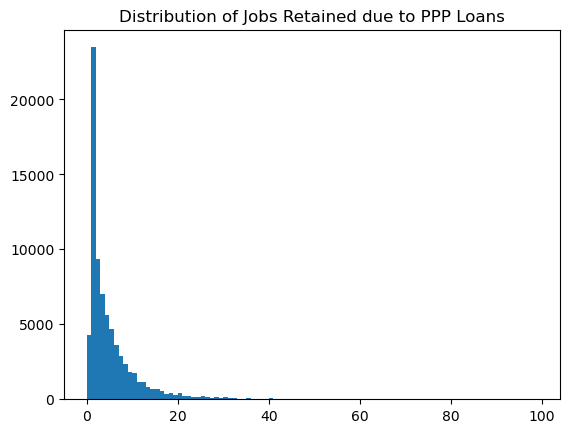

In [7]:
plt.hist(data['JobsRetained'],bins=np.arange(0,100,1))
plt.title('Distribution of Jobs Retained due to PPP Loans');

<h4>NAICSCode</h4>

Here I will simplify NAICSCode by categorizing each business according to its top-level industry.

In [8]:
naics_count = len(data['NAICSCode'].unique())
print('Number of unique NAICS Codes: ',naics_count)

Number of unique NAICS Codes:  1003


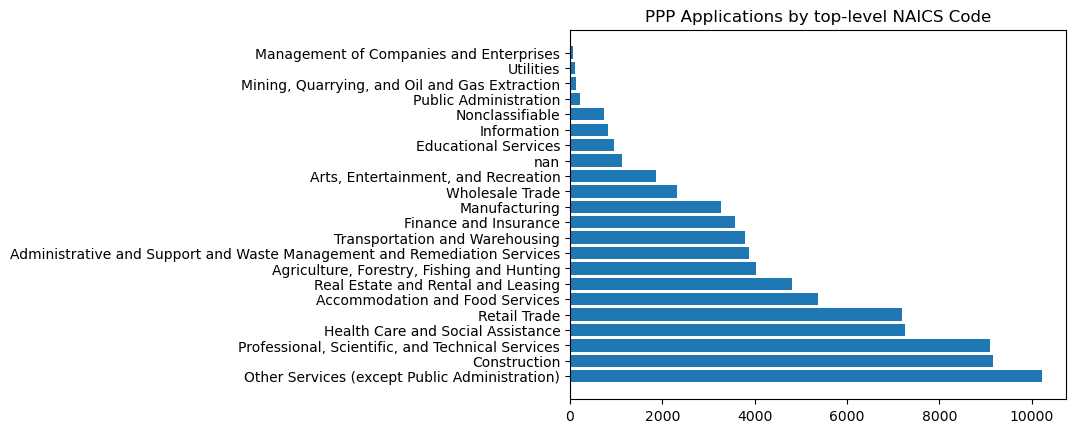

In [9]:
# Taken from Census Bureau site cited above:
naics_dict = {
    0: 'nan',
    11: 'Agriculture, Forestry, Fishing and Hunting',
    21: 'Mining, Quarrying, and Oil and Gas Extraction',
    22: 'Utilities',
    23: 'Construction',
    31: 'Manufacturing',
    32: 'Manufacturing',
    33: 'Manufacturing',
    42: 'Wholesale Trade',
    44: 'Retail Trade',
    45: 'Retail Trade',
    48: 'Transportation and Warehousing',
    49: 'Transportation and Warehousing',
    51: 'Information',
    52: 'Finance and Insurance',
    53: 'Real Estate and Rental and Leasing',
    54: 'Professional, Scientific, and Technical Services',
    55: 'Management of Companies and Enterprises',
    56: 'Administrative and Support and Waste Management and Remediation Services',
    61: 'Educational Services',
    62: 'Health Care and Social Assistance',
    71: 'Arts, Entertainment, and Recreation',
    72: 'Accommodation and Food Services',
    81: 'Other Services (except Public Administration)',
    92: 'Public Administration',
    99: 'Nonclassifiable'
}

def top_level_naics(code):
    code2 = str(code)[:2]
    if code2 == 'na':
        return 0
    else:
        return int(code2)

data['naics'] = [naics_dict[top_level_naics(code)] for code in data['NAICSCode']]
plt.title('PPP Applications by top-level NAICS Code')
vals = data['naics'].value_counts()
plt.barh(vals.keys(),width=vals);

<h4>BusinessType</h4>

This categorical variable should provde very useful. I will group categories with a small number of data points into an "other" bucket.

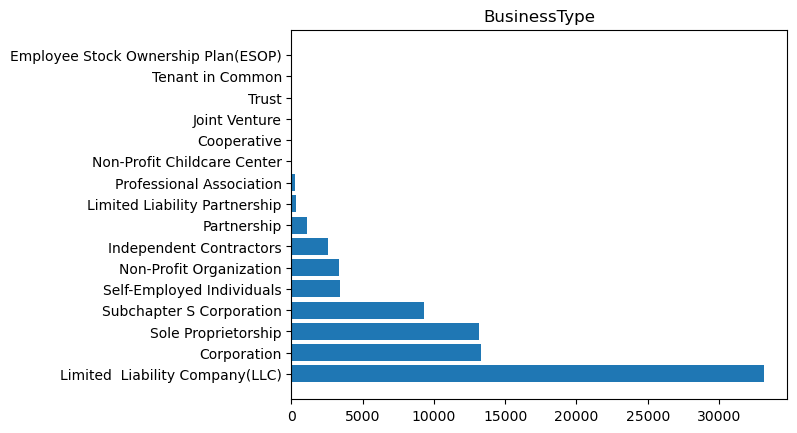

In [10]:
plt.title('BusinessType')
vals = data['BusinessType'].value_counts()
plt.barh(vals.keys(),width=vals);

<h4>CD</h4>

This categorical variable has 8 distinct values, one for each congressional district in the state. These will be a proxy for regional effects.

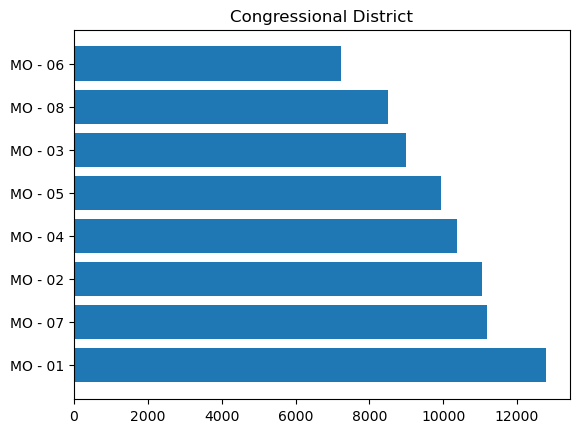

In [11]:
plt.title('Congressional District')
vals = data['CD'].value_counts()
plt.barh(vals.keys(),width=vals);

<h3>Data Cleaning</h3>

The next step is to drop some of the variables due to non-response bias or lack of usability for those categorical variables with too many categories. Additionally, NonProfit must be changed from a binary 'Y' or null to a TRUE or FALSE boolean. Lastly, I will drop NaNs from the DataFrame and verify that we still have enough data to work with

In [12]:
data['nonprofit'] = data['NonProfit'] == 'Y'
data['MonthApproved'] = pd.to_datetime(data['DateApproved']).dt.month
for variable in ['City','State','Zip','NAICSCode','RaceEthnicity','Gender','Veteran','NonProfit','Lender','DateApproved']:
    data = data.drop(variable, axis=1)

In [13]:
data_before = len(data)
data = data.dropna()
data_after = len(data)
data.info()
print('Records removed:',data_before - data_after,'of',data_before,'records')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75843 entries, 0 to 80034
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LoanAmount     75843 non-null  float64
 1   BusinessType   75843 non-null  object 
 2   JobsRetained   75843 non-null  float64
 3   CD             75843 non-null  object 
 4   naics          75843 non-null  object 
 5   nonprofit      75843 non-null  bool   
 6   MonthApproved  75843 non-null  int64  
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 4.1+ MB
Records removed: 4192 of 80035 records


We lost about 4 thousand records from the original 80 thousand. This means the vast majority were retained, and we certainly still have enough to work with in creating a regression model. Let's take a look at our cleaned dataset and a graph visualizing the relationship between LoanAmount and JobsRetained (the primary predictor and output variables).

In [14]:
text='''
sns.kdeplot(data=data, x=np.log(data.LoanAmount), y=np.log(data.JobsRetained), fill=True)
plt.title('Density of JobsRetained by LoanAmount')
plt.xlabel('Log LoanAmount')
plt.ylabel('Log JobsRetained')
plt.show()
'''

<h3>Model: Multilinear Regression</h3>

I will be using a multilinear regression model to predict JobsRetained using the continuous variable LoanAmount as well as the categorical variables BusinessType, CD (a proxy for regional effects), naics, nonprofit, and MonthApproved. Additionally, I will include the cross effects between variables and a second-order polynomial of LoanAmount, pruning those predictors with insufficient p-values. Many of the categorical variables contain a number of categories and some categories have a very small number of samples, so I may need to combine small categories into "other" and remove dummy variables for those with low p-values to achieve a stronger result. Ultimately since there is only one continuous variable, the cross effects of different categorical variables on it will be where most of the insight comes from. For example, while JobsRetained clearly increases with LoanAmount, it's likely that this relationship varies by industry (naics), organization type (BusinessType), and region (CD).

The first step is to convert categorical variables into boolean columns:

In [15]:
# final formatting of data for regression analysis

# convert Congressional District field of 8 categories into 8 true/false categorical variable columns:
for i in range(1,9):
    data['CD' + str(i)] = data['CD'] == 'MO - 0' + str(i)

# convert BusinessType into 4 categorical variables based on 4 most frequent categories:
data['LLC'] = data.BusinessType == 'Limited  Liability Company(LLC)'
data['Corporation'] = data.BusinessType == 'Corporation'
data['SoleProprietorship'] = data.BusinessType == 'Sole Proprietorship'
data['Scorp'] = data.BusinessType == 'Subchapter S Corporation'

# convert naics into 11 categorical variables based on the most frequent categories:
data['Construction'] = data.naics == 'Construction'
data['PST'] = data.naics == 'Professional, Scientific, and Technical Services'
data['Healthcare'] = data.naics == 'Health Care and Social Assistance'
data['Retail'] = data.naics == 'Retail Trade'
data['Accomodation'] = data.naics == 'Accommodation and Food Services'
data['RealEstate'] = data.naics == 'Real Estate and Rental and Leasing'
data['Agriculture'] = data.naics == 'Agriculture, Forestry, Fishing and Hunting'
data['Admin'] = data.naics == 'Administrative and Support and Waste Management and Remediation Services'
data['Transportation'] = data.naics == 'Transportation and Warehousing'
data['Finance'] = data.naics == 'Finance and Insurance'
data['Manufacturing'] = data.naics == 'Manufacturing'

# convert MonthApproved into 3 categorical variables based on month:
data['April'] = data.MonthApproved == 4
data['May'] = data.MonthApproved == 5
data['June'] = data.MonthApproved == 6

# sort the data by the dependent variable:
data = data.sort_values(by=['JobsRetained'])

<h4>Assumption of Linearity</h4>
The primary relationship in the model is the impact of LoanAmount on JobsRetained, with the many categorical variables potentially representing a modification of this relationship (ex: one industry retaining more jobs per loan dollar). A _linear_ regression relies on the assumption of a linear relationship between the continuous variables. Below is the average JobsRetained per $5,000 LoanAmount bucket. The relationship does seem to align with this assumption:

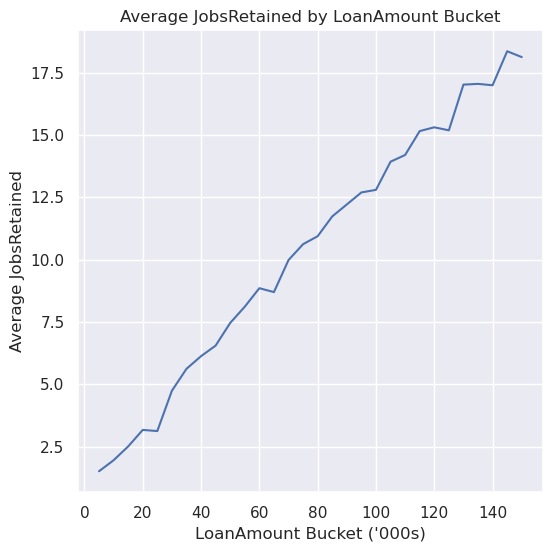

In [16]:
x = np.arange(5000,155000,5000)
y = [np.average(data['JobsRetained'][data['LoanAmount'] < bucket][data['LoanAmount'] >= bucket-5000]) for bucket in x]
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Average JobsRetained by LoanAmount Bucket')
plt.xlabel('LoanAmount Bucket (\'000s)')
plt.ylabel('Average JobsRetained')
plt.plot(x/1000,y);

<h3>Outliers and Highly Leveraged Points</h3>

To get a sense of outliers and leverage, I will use two plots. The first is a scatterplot, revealing many points that are far outside the typical range of JobsRetained. However, with more than 75,000 data points, it's not clear that the outliers are necessarily leveraged enough to distort the regression model. The second plot shows the impact on a simple linear model's R-square value of removing the maximum k data points by JobsRetained. It is here that we can see the outsize impact many of these points are making, and as we can see in the original scatterplot, the outliers are not skewed one way or another along the LoanAmount axis in a way that might cause its own distortion should they be removed. The improvement to R-square starts to level off after just a few removals, with a sharp "kink" in the curve. Based on this, I aim to remove those highly leveraged points before the sharp turn. Based on the plot, this occurs somewhere around 30, so I will remove the 30 largest outliers.

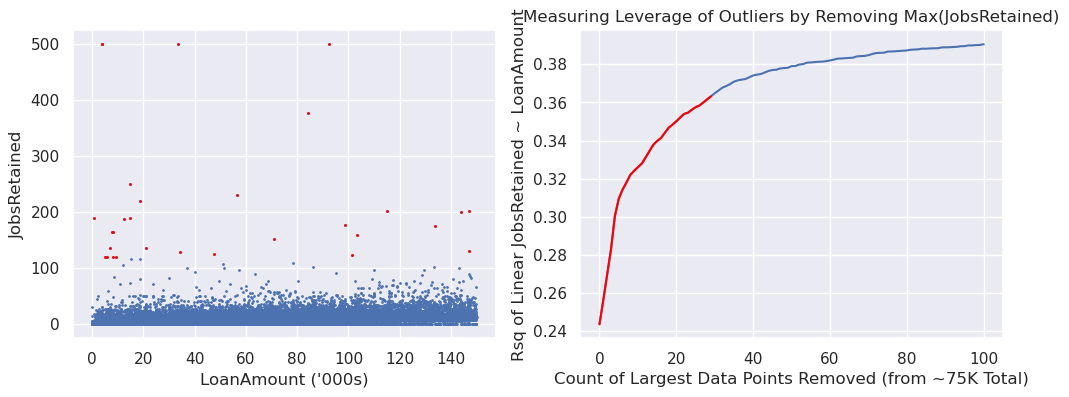

In [17]:
plt.figure(2, figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel('LoanAmount (\'000s)')
plt.ylabel('JobsRetained')
plt.scatter(data['LoanAmount']/1000,data['JobsRetained'],s=1)
plt.scatter(data[-30:]['LoanAmount']/1000,data[-30:]['JobsRetained'],s=1,color='red')

plt.subplot(1,2,2)
x = list(np.arange(0,101,1))
y = []
for i in x:
    if i == 0:
        model_with_outlier_removed = smf.ols(formula='JobsRetained ~ LoanAmount',data=data).fit()
    else:
        model_with_outlier_removed = smf.ols(formula='JobsRetained ~ LoanAmount',data=data[:-i]).fit()
    rsquared_adj = model_with_outlier_removed.rsquared_adj
    y = y + [rsquared_adj]
    
plt.title('Measuring Leverage of Outliers by Removing Max(JobsRetained)')
plt.xlabel('Count of Largest Data Points Removed (from ~75K Total)')
plt.ylabel('Rsq of Linear JobsRetained ~ LoanAmount')
plt.plot(x,y)
plt.plot(x[:30],y[:30], color='red');

<h3>Measuring R-Square of Individual Predictors<h/3>

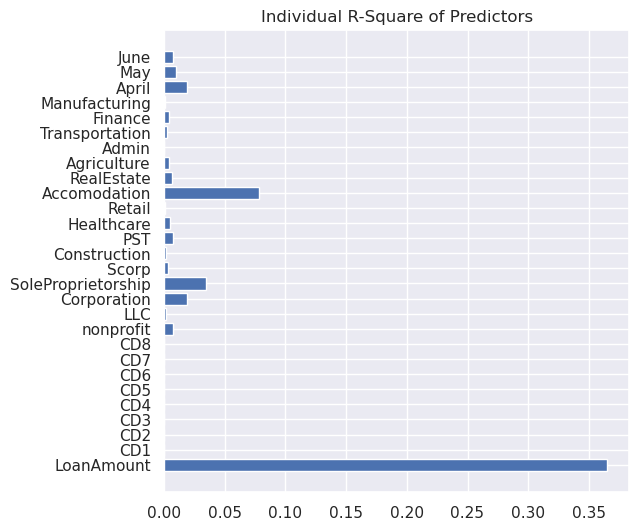

In [18]:
predictors = ['LoanAmount', # primary continuous predictor variable
              'CD1','CD2','CD3','CD4','CD5','CD6','CD7','CD8', # regional effects
              'nonprofit', # profit/nonprofit boolean
              'LLC','Corporation','SoleProprietorship','Scorp', # organization type effect
              'Construction','PST','Healthcare','Retail','Accomodation','RealEstate','Agriculture','Admin','Transportation','Finance','Manufacturing', # industry effect
              'April','May','June'] # loan approval timing effect

reg_data = pd.DataFrame()
reg_data['JobsRetained'] = data['JobsRetained']
for predictor in predictors:
    reg_data[predictor] = data[predictor]

# remove 30 largest values of JobsRetained due to being outliers with high leverage as identified above
reg_data = reg_data[:-30]

individual_rsquares = [smf.ols(formula='JobsRetained ~ ' + predictor, data=reg_data).fit().rsquared for predictor in predictors]
plt.figure(figsize=(6,6))
plt.title('Individual R-Square of Predictors')
plt.barh(y=predictors, width=individual_rsquares);

<h3>Correlation Matrix</h3>
Generally speaking most variables are fairly uncorrelated. A few we will have to watch out for during model construction to avoid colinearity, such as the approval month and the organization type.

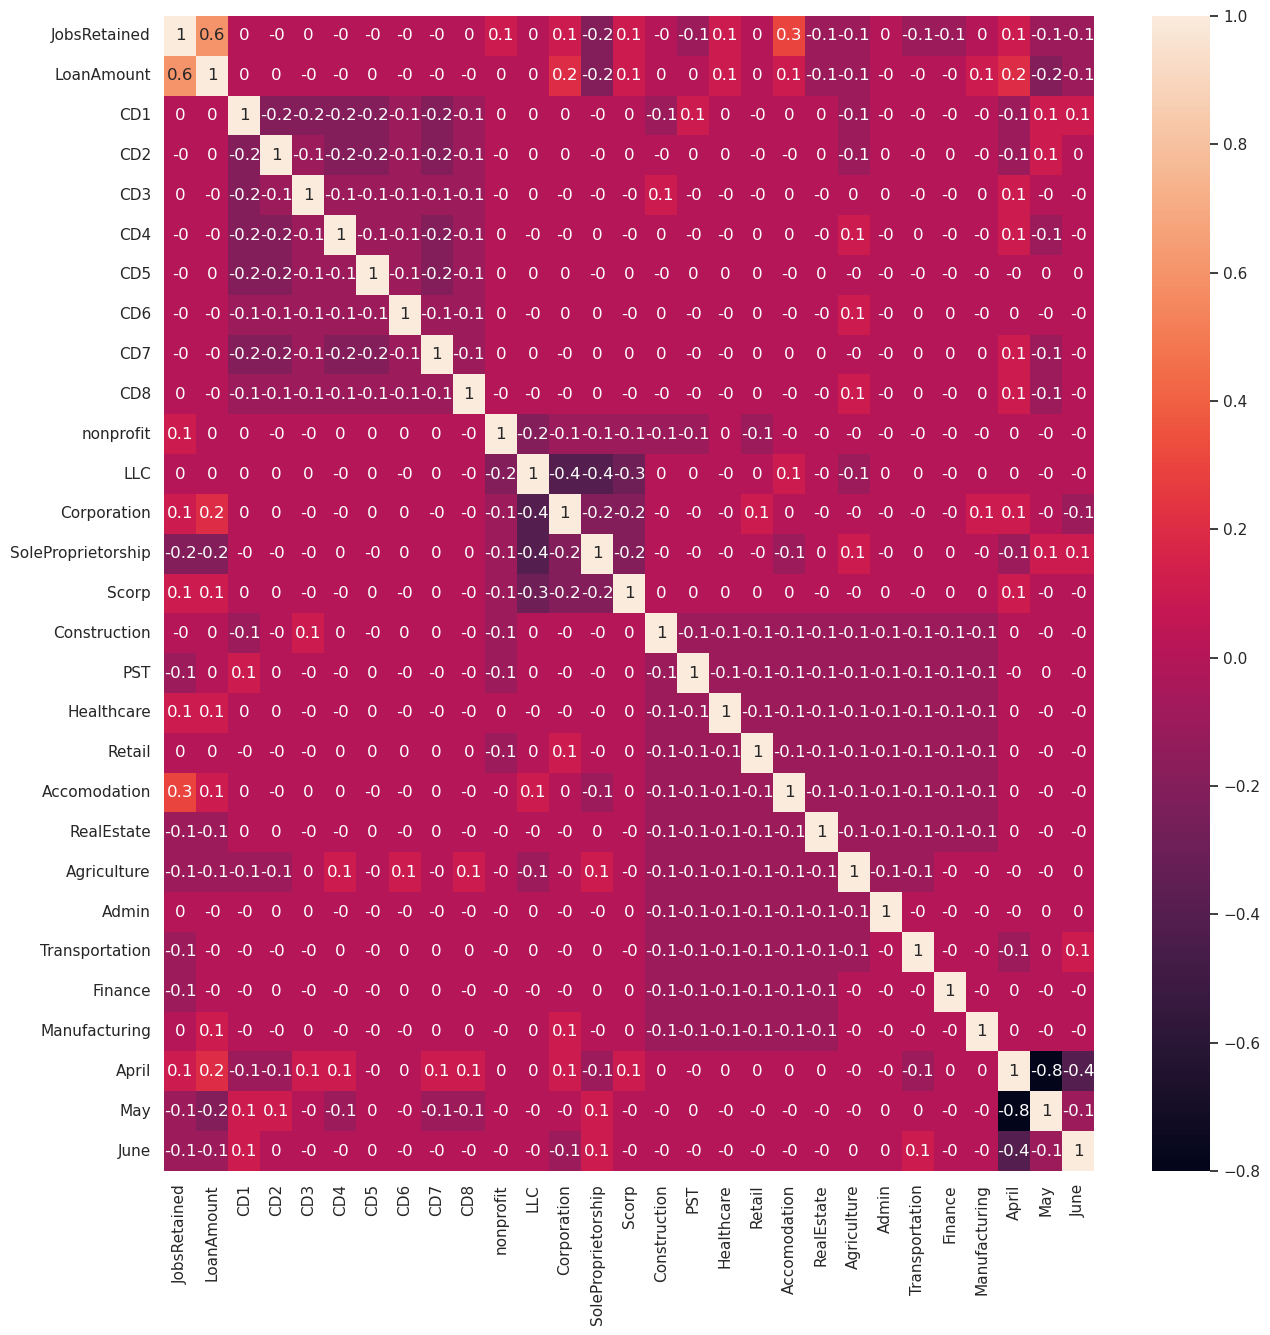

In [19]:
corr_matrix = reg_data.corr()
for k in corr_matrix.keys():
    for i in range(len(corr_matrix[k])):
        corr_matrix[k][i] = np.round(corr_matrix[k][i],1)
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True);

<h3>Multilinear Stepwise Regression</h3>
The first step in fitting a multilinear regression through stepwise addition of predictors is to create a list of potential predictors to cycle through. Since the primary continuous predictor is LoanAmount, I construct a list of cross-effect predictors for each categorical variable and LoanAmount. The model will automatically include the base effect of a predictor is its cross-effect with LoanAmount is included in accordance with best practice.

Next, training and testing datasets will be constructed as 10% random samples from the cleaned data. The stepwise() function will create a k-predictor model in stepwise fashion to maximize adjusted r-square on the training data up to k=10, and this will be graphed alongside the adjusted r-square of the model on the testing data in order to identity an inflection point at which to stop adding predictor variables.

In [20]:
all_predictors = []
for i in reg_data.keys()[1:]:
    all_predictors = all_predictors + ['LoanAmount*' + i]
print('total potential predictors:',len(all_predictors))

total potential predictors: 28


In [21]:
# Implementation of stepwise multilinear regression
# stepwise() returns the order of features used and the associated
# rsquared_adj for training and testing data for hyperparameter tuning
def stepwise(training_data, testing_data, target_variable, allowed_factors, k):
    rsqs_adj = []
    testing_rsqs_adj = []
    factors_used = []
    # find the incremental best feature to include to maximize adjusted r-squared
    for i in range(k):
        formula_string = target_variable + ' ~ ' + '+'.join(factors_used)
        rsqs = []
        for factor in allowed_factors:
            if factor in factors_used:
                rsqs = rsqs + [0]
            else:
                formula_string = target_variable + ' ~ ' + '+'.join([*factors_used,factor])
                regr = smf.ols(formula=formula_string,data=training_data).fit()
                rsqs = rsqs + [regr.rsquared_adj]
        
        # add the incremental factor and its adj_rsq on the training and test data to the output lists
        max_rsq_factor = rsqs.index(max(rsqs))
        factors_used = factors_used + [allowed_factors[max_rsq_factor]]
        rsqs_adj = rsqs_adj + [max(rsqs)]
        
        # calculate rsquared_adj for the testing data
        formula_string = 'JobsRetained ~ ' + '+'.join(factors_used)
        regr = smf.ols(formula=formula_string,data=training_data).fit()
        yhat = regr.predict(testing_data)
        ssr = np.sum((testing_data['JobsRetained'] - yhat)**2)
        sst = np.sum((testing_data['JobsRetained'] - np.average(testing_data['JobsRetained']))**2)
        rsq_adj = 1 - (ssr/sst)*(regr.df_resid + regr.df_model)/regr.df_resid
        testing_rsqs_adj = testing_rsqs_adj + [rsq_adj]
        
    return factors_used, rsqs_adj, testing_rsqs_adj

In [22]:
# Construct Training & Testing Datasets with 80/20 split
reg_data = shuffle(reg_data, random_state=0)
first80index = round(0.8 * len(reg_data))
training_data = reg_data[:first80index]
testing_data  = reg_data[first80index:]

# Get the Relevant Values from a Stepwise Regression:
train_reg_features, train_rsqs_adj, test_rsqs_adj = stepwise(training_data, testing_data, 'JobsRetained', all_predictors, 28)

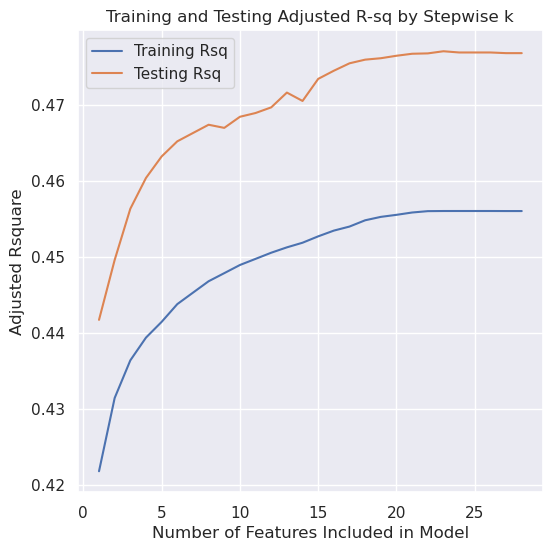

In [23]:
x = list(range(1,len(train_reg_features)+1))
plt.figure(figsize=(6,6))
plt.title('Training and Testing Adjusted R-sq by Stepwise k')
plt.plot(x,train_rsqs_adj, label='Training Rsq')
plt.plot(x,test_rsqs_adj, label='Testing Rsq')
plt.xlabel('Number of Features Included in Model')
plt.ylabel('Adjusted Rsquare')
plt.legend();

<h4>Tuning Hyperparameter k</h4>

The hyperparameter of my model is stepwise k, the number of features to include in the multilinear regression. The graph above demonstrates that additional features have a diminishing positive impact on adjusted R-squared. The curve begins levelling off somewhere around 20 features. While a decline in the adjusted R-square on the testing data might normally indicate how many features to include for maximum predictability, ultimately the purpose of my regression is explainability, so I will still go with a model with a smaller k despite the apparent robustness of features at least up to the k=20 level or so. The details of the model for k=8 on the total dataset is shown below (Note that k represents the count of cross-impact features between the categorical variables and the continuous feature LoanAmount, so while k=8, there are essentially 2k features shown as each features corresponding direct impact must be included according to best practices):

In [24]:
regr = smf.ols(formula='JobsRetained ~ ' + '+'.join(train_reg_features[:8]), data=reg_data).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           JobsRetained   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     3665.
Date:                Tue, 08 Aug 2023   Prob (F-statistic):               0.00
Time:                        17:09:28   Log-Likelihood:            -2.2870e+05
No. Observations:               75813   AIC:                         4.574e+05
Df Residuals:                   75795   BIC:                         4.576e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 1.3359      0.039     34.524      0.000       1.260       1.412
Accomodation[T.True]                      1.7502      0.115     15.237      0.000       1.525       1.975
nonprofit[T.True]                        -0.0791      0.135     -0.587      0.557      -0.344       0.185
PST[T.True]                              -0.5200      0.082     -6.332      0.000      -0.681      -0.359
Retail[T.True]                            0.4167      0.091      4.577      0.000       0.238       0.595
Construction[T.True]                      0.0567      0.083      0.685      0.493      -0.106       0.219
Finance[T.True]                          -0.3454      0.130     -2.653      0.008      -0.601      -0.090
RealEstate[T.True]                       -0.6094      0.105     -5.822      0.000      -0.815      -0.404
SoleProprietorship[T.True]               -0.6907      0.066    -10.444      0.000      -0.820      -0.561
LoanAmount                                0.0001   8.31e-07    136.201      0.000       0.000       0.000
LoanAmount:Accomodation[T.True]        8.473e-05   2.04e-06     41.450      0.000    8.07e-05    8.87e-05
LoanAmount:nonprofit[T.True]           5.403e-05   2.63e-06     20.553      0.000    4.89e-05    5.92e-05
LoanAmount:PST[T.True]                -3.068e-05   1.82e-06    -16.845      0.000   -3.42e-05   -2.71e-05
LoanAmount:Retail[T.True]              1.308e-05   2.02e-06      6.465      0.000    9.11e-06     1.7e-05
LoanAmount:Construction[T.True]       -2.689e-05   1.76e-06    -15.273      0.000   -3.03e-05   -2.34e-05
LoanAmount:Finance[T.True]            -3.652e-05   3.42e-06    -10.686      0.000   -4.32e-05   -2.98e-05
LoanAmount:RealEstate[T.True]         -1.756e-05   3.03e-06     -5.795      0.000   -2.35e-05   -1.16e-05
LoanAmount:SoleProprietorship[T.True] -1.365e-06   2.86e-06     -0.477      0.634   -6.98e-06    4.25e-06
==============================================================================
Omnibus:                    77099.068   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10362090.441
Skew:                           4.768   Prob(JB):                         0.00
Kurtosis:                      59.474   Cond. No.                     3.84e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<h3>Regression Analysis</h3>

<h4>P-Values</h4>

The cross-impact features are all statistically significant at a p = 0.05 level, so their corresponding direct impact features are all left in despite one, Construction, being not statistically significant.

<h4>Interpretation</h4>

The model parameters describe the impact of an additional PPP loan dollar on the expected number of jobs retained through the program. A useful starting point for analysis is the zero-dollar case, the theoretical baseline where the loan doesn't exist and the model's output is 0.9454 jobs retained. Importantly, a substantial minority of PPP loans in this dataset explicitly retained 0 jobs, so a baseline of saving about 1 job does suggest that certain characteristics of the organization seeking PPP assistance reduced the likelihood they saved any positions.

Because of the understandably small impact of a single incremental loaned dollar, I will be describing the impact of a $10,000 increase in a PPP loan on jobs retained. Remember, the dataset covers Missouri PPP loan recipients of 250K or less. The base case incremental impact of such an increase in the amount loaned is 1 additional job retained. I have summarized the impact of the features included in the final model below:

The Accomodation & Food (variable name: Accomodation) industry represented a significantly improved efficiency of funds spent in terms of jobs retained over other industries. The baseline organization was expected to retained 1.7 additional jobs, with each additional $10,000 in funding associated with 0.8 more jobs saved. The Retail and Construction industries had smaller but still positive effects relative to others as well. This is consistent with what I would expect from industries so sensitive to the negative economic effects of the Covid-19 pandemic. Another aspect associated with high value for money loaned was the organization having non-profit status. In terms of legal status, LLCs also demonstrated better value for loan dollars spent relative to others.

Certain features were associated with relatively worse value for money loaned. These were the industry categories of Finance, "Professional, Scientific, and Technical Services," and Real Estate and additionally, the legal status of Sole Proprietorship. Not only were these features associated with a lower baseline number of jobs saved, but experienced lower incremental job gains with higher loan amounts. This could be due to these industries potentially featuring overall relatively higher-paid workers, meaning the cost of covering paychecks was higher per employee, increasing loan amounts without as many jobs retained. Sole Proprietorships are as they sound, often businesses with one employer/owner, so it makes sense that many would save few jobs with their PPP loans simply because the amount of employees per proprietorship is lower.